<img src="../Udacity_DL_Nanodegree/031%20RNN%20Super%20Basics/SimpleRNN01.png" align="left"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb

In [2]:
# Encoding: 'a'=[0,0,1] 'b'=[0,1,0] 'c'=[1,0,0]

#                            < ----- 4x time steps ----- >
x_train = np.array([    
                    [ [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0] ],  #  'bbcb'
                    [ [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0] ],  #  'cbcb'   ^
                    [ [0, 1, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0] ],  #  'bcbc'   ^
                    [ [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0] ],  #  'cbbc'   ^
                    [ [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0] ],  #  'ccbc'   ^
    
    
                    [ [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0] ],  #  'bacb'   | 9x batch size
                    [ [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1] ],  #  'ccba'   v
                    [ [0, 0, 1], [1, 0, 0], [0, 1, 0], [1, 0, 0] ],  #  'acbc'   ^
                    [ [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0] ],  #  'cbac'   ^
                    
                    [ [0, 1, 0], [0, 0, 1], [0, 0, 1], [0, 1, 0] ],  #  'baab'
                    [ [0, 0, 1], [0, 0, 1], [0, 1, 0], [1, 0, 0] ],  #  'aabc'
    
                    [ [0, 0, 1], [1, 0, 0], [0, 0, 1], [0, 0, 1] ],  #  'acaa'
                   ])
y_train = np.array([ [0],   # <->  no timesteps
                     [0],   #
                     [0],   #
                     [0],   #
                     [0],   #
                    
                     [1],   #  ^
                     [1],   #  |  9x batch size
                     [1],   #  ^
                     [1],   #  |  9x batch size
                    
                     [0],   #  v
                     [0],   #
                    
                     [1] ]) #
x_test = np.array([
                   [ [0,1,0], [1,0,0], [1,0,0], [0,1,0] ],  #  'bccb' -> 0
                   [ [1,0,0], [1,0,0], [0,1,0], [1,0,0] ],  #  'ccbb' -> 0
                   [ [0,1,0], [1,0,0], [0,0,1], [1,0,0] ],  #  'bcac' -> 1
                   [ [0,1,0], [0,0,1], [1,0,0], [0,1,0] ],  #  'bacb' -> 1
                  ])

In [3]:
x_int = np.random.choice(3, size=10)

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_der(x):
    return 1.0 - np.tanh(x)**2

In [5]:
def fwd(x, Wxh, Whh, Who):
    assert x.ndim==3 and x.shape[1:]==(4, 3)
    
    x_t0 = x[:,0,:]
    x_t1 = x[:,1,:]
    x_t2 = x[:,2,:]
    x_t3 = x[:,3,:]
        
    s_init = np.zeros([len(x), len(Whh)])   # [n_batch, n_hid]
    z_t0 = s_init @ Whh + x_t0 @ Wxh
    s_t0 = tanh(z_t0)
    z_t1 = s_t0 @ Whh + x_t1 @ Wxh
    s_t1 = tanh(z_t1)
    z_t2 = s_t1 @ Whh + x_t2 @ Wxh
    s_t2 = tanh(z_t2)
    z_t3 = s_t2 @ Whh + x_t3 @ Wxh
    s_t3 = tanh(z_t3)
    z_out = s_t3 @ Who
    y_hat = sigmoid( z_out )
    
    return y_hat

In [7]:
def back(x, y, Wxh, Whh, Who):
    assert x.ndim==3 and x.shape[1:]==(4, 3)
    assert y.ndim==2 and y.shape[1:]==(1,)
    assert len(x) == len(y)
    
    # Forward
    x_t0 = x[:,0,:]
    x_t1 = x[:,1,:]
    x_t2 = x[:,2,:]
    x_t3 = x[:,3,:]
        
    s_init = np.zeros([len(x), len(Whh)])   # [n_batch, n_hid]
    z_t0 = s_init @ Whh + x_t0 @ Wxh
    s_t0 = tanh(z_t0)
    z_t1 = s_t0 @ Whh + x_t1 @ Wxh
    s_t1 = tanh(z_t1)
    z_t2 = s_t1 @ Whh + x_t2 @ Wxh
    s_t2 = tanh(z_t2)
    z_t3 = s_t2 @ Whh + x_t3 @ Wxh
    s_t3 = tanh(z_t3)
    z_out = s_t3 @ Who
    y_hat = sigmoid( z_out )
    
    # Backward
    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh)
    dWho = np.zeros_like(Who)
    
    err = -(y-y_hat)/len(x) * sigmoid_der( z_out )
    dWho = s_t3.T @ err
    ro_t3 = err @ Who.T * tanh_der(z_t3)
    
    dWxh += x_t3.T @ ro_t3
    dWhh += s_t2.T @ ro_t3
    ro_t2 = ro_t3 @ Whh.T * tanh_der(z_t2)
    
    dWxh += x_t2.T @ ro_t2
    dWhh += s_t1.T @ ro_t2
    ro_t1 = ro_t2 @ Whh.T * tanh_der(z_t1)
    
    dWxh += x_t1.T @ ro_t1
    dWhh += s_t0.T @ ro_t1
    ro_t0 = ro_t1 @ Whh.T * tanh_der(z_t0)
    
    dWxh += x_t0.T @ ro_t0
    dWhh += s_init.T @ ro_t0
    
    return y_hat, dWxh, dWhh, dWho

In [8]:
def mse(x, y, Wxh, Whh, Who):
    y_hat = fwd(x, Wxh, Whh, Who)
    return 0.5 * np.mean((y-y_hat)**2)

In [94]:
def fwd(x, Wxh, Whh, Who):
    assert x.ndim==3 and x.shape[1:]==(4, 3)
    
    x_t = {}
    s_t = {}
    z_t = {}
    s_t[-1] = np.zeros([len(x), len(Whh)])   # [n_batch, n_hid]
    T = x.shape[1]
    
    for t in range(T):
        x_t[t] = x[:,t,:]
        z_t[t] = s_t[t-1] @ Whh + x_t[t] @ Wxh
        s_t[t] = tanh(z_t[t])
    
    z_out = s_t[t] @ Who
    y_hat = sigmoid( z_out )
    
    return y_hat

In [95]:
def back(x, y, Wxh, Whh, Who):
    assert x.ndim==3 and x.shape[1:]==(4, 3)
    assert y.ndim==2 and y.shape[1:]==(1,)
    assert len(x) == len(y)
    
    # Init
    x_t = {}
    s_t = {}
    z_t = {}
    s_t[-1] = np.zeros([len(x), len(Whh)])   # [n_batch, n_hid]
    T = x.shape[1]
        
    # Forward
    for t in range(T):                                  # t = [0, 1, 2, 3]
        x_t[t] = x[:,t,:]                               # pick time-step input          x_[t].shape = (n_batch, n_in)
        z_t[t] = s_t[t-1] @ Whh + x_t[t] @ Wxh
        s_t[t] = tanh(z_t[t])
    z_out = s_t[t] @ Who
    y_hat = sigmoid( z_out )
    
    # Backward
    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh)
    dWho = np.zeros_like(Who)
    
    ro = -(y-y_hat)/len(x) * sigmoid_der( z_out )       # Backprop through loss funt.
    dWho = s_t[t].T @ ro                                # 
    ro = ro @ Who.T * tanh_der(z_t[t])                  # Backprop into hidden state
    
    for t in reversed(range(T)):                        # t = [3, 2, 1, 0]
        dWxh += x_t[t].T @ ro
        dWhh += s_t[t-1].T @ ro
        if t != 0:                                      # don't backprop into t=-1
            ro = ro @ Whh.T * tanh_der(z_t[t-1])        # Backprop into previous time step
    
    # Backward
    
#     err = -(y-y_hat)/len(x) * sigmoid_der( z_out )
#     dWho = s_t3.T @ err
#     ro_t3 = err @ Who.T * tanh_der(z_t3)

#     dWxh += x_t3.T @ ro_t3
#     dWhh += s_t2.T @ ro_t3
#     ro_t2 = ro_t3 @ Whh.T * tanh_der(z_t2)

#     dWxh += x_t2.T @ ro_t2
#     dWhh += s_t1.T @ ro_t2
#     ro_t1 = ro_t2 @ Whh.T * tanh_der(z_t1)

#     dWxh += x_t1.T @ ro_t1
#     dWhh += s_t0.T @ ro_t1
#     ro_t0 = ro_t1 @ Whh.T * tanh_der(z_t0)

#     dWxh += x_t0.T @ ro_t0
#     dWhh += s_init.T @ ro_t0
    
    return y_hat, dWxh, dWhh, dWho

In [93]:
test_gradient()

#### Train

In [15]:
np.random.seed(0)
W_xh = 0.1 * np.random.randn(3, 2)  # Wxh.shape: [n_in, n_hid]
W_hh = 0.1 * np.random.randn(2, 2)  # Whh.shape: [n_hid, n_hid]
W_ho = 0.1 * np.random.randn(2, 1)  # Who.shape: [n_hid, n_out]

In [16]:
def train_rnn(x, y, nb_epochs, learning_rate, Wxh, Whh, Who):
    
    losses = []
    
    for e in range(nb_epochs):
        
        y_hat, dWxh, dWhh, dWho = back(x, y, Wxh, Whh, Who)
        
        Wxh += -learning_rate * dWxh
        Whh += -learning_rate * dWhh
        Who += -learning_rate * dWho
        
        # Log and print
        loss_train = mse(x, y, Wxh, Whh, Who)
        losses.append(loss_train)
        if e % (nb_epochs / 10) == 0:
            print('loss ', loss_train.round(4))
        
    return losses
        

In [17]:
losses = train_rnn(x_train, y_train, 3000, 0.1, W_xh, W_hh, W_ho)

loss  0.1261
loss  0.1247
loss  0.1212
loss  0.1057
loss  0.0892
loss  0.0766
loss  0.0651
loss  0.0469
loss  0.0217
loss  0.0092


In [18]:
fwd(x_train, W_xh, W_hh, W_ho).round(0)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.]])

In [27]:
fwd(x_test, W_xh, W_hh, W_ho).round(0)

array([[0.],
       [0.],
       [1.],
       [1.]])

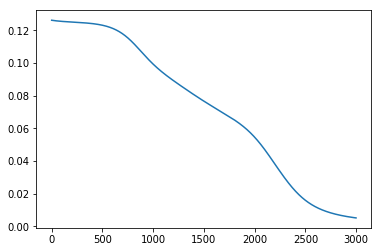

In [20]:
plt.plot(losses)

#### Test Grad

In [21]:
# test backward
_, dW_xh, dW_hh, dW_ho = back(x_train, y_train, W_xh, W_hh, W_ho)
print('dW_xh', dW_xh)
print('dW_hh', dW_hh)
print('dW_ho', dW_ho)

dW_xh [[-0.00141006 -0.00181138]
 [-0.00222526 -0.00256484]
 [-0.0006515   0.00162391]]
dW_hh [[ 0.00050641  0.00406317]
 [-0.00127919 -0.00321661]]
dW_ho [[0.00022729]
 [0.00575002]]


In [22]:
# test numerical gradient
ngW_xh, ngW_hh, ngW_ho = ngrad(x_train, y_train, W_xh, W_hh, W_ho)
print('ngW_xh', ngW_xh)
print('ngW_hh', ngW_hh)
print('ngW_ho', ngW_ho)

ngW_xh [[-0.00141006 -0.0018114 ]
 [-0.00222526 -0.00256484]
 [-0.0006515   0.00162391]]
ngW_hh [[ 0.00050641  0.00406316]
 [-0.00127919 -0.00321661]]
ngW_ho [[0.00022729]
 [0.00575002]]


In [23]:
assert np.allclose(dW_xh, ngW_xh)
assert np.allclose(dW_hh, ngW_hh)
assert np.allclose(dW_ho, ngW_ho)

In [11]:
def ngrad(x, y, Wxh, Whh, Who):
    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh)
    dWho = np.zeros_like(Who)
    eps = 1e-4
    
    for r in range(len(Wxh)):
        for c in range(Wxh.shape[1]):
            Wxh_pls = Wxh.copy()
            Wxh_min = Wxh.copy()
            
            Wxh_pls[r, c] += eps
            Wxh_min[r, c] -= eps
            
            l_pls = mse(x, y, Wxh_pls, Whh, Who)
            l_min = mse(x, y, Wxh_min, Whh, Who)
            
            dWxh[r, c] = (l_pls - l_min) / (2*eps)
    
    for r in range(len(Whh)):
        for c in range(Whh.shape[1]):
            Whh_pls = Whh.copy()
            Whh_min = Whh.copy()
            
            Whh_pls[r, c] += eps
            Whh_min[r, c] -= eps
            
            l_pls = mse(x, y, Wxh, Whh_pls, Who)
            l_min = mse(x, y, Wxh, Whh_min, Who)
            
            dWhh[r, c] = (l_pls - l_min) / (2*eps)
    
    for r in range(len(Who)):
        for c in range(Who.shape[1]):
            Who_pls = Who.copy()
            Who_min = Who.copy()
            
            Who_pls[r, c] += eps
            Who_min[r, c] -= eps
            
            l_pls = mse(x, y, Wxh, Whh, Who_pls)
            l_min = mse(x, y, Wxh, Whh, Who_min)
            
            dWho[r, c] = (l_pls - l_min) / (2*eps)
    
    
    return dWxh, dWhh, dWho

In [13]:
def test_gradient():
    for i in range(100):
        W_xh = 0.1 * np.random.randn(3, 2)  # Wxh.shape: [n_in, n_hid]
        W_hh = 0.1 * np.random.randn(2, 2)  # Whh.shape: [n_hid, n_hid]
        W_ho = 0.1 * np.random.randn(2, 1)  # Who.shape: [n_hid, n_out]

        xx = np.random.randn(100, 4, 3)
        yy = np.random.randint(0, 2, size=[100, 1])

        _, dW_xh, dW_hh, dW_ho = back(xx, yy, W_xh, W_hh, W_ho)
        ngW_xh, ngW_hh, ngW_ho = ngrad(xx, yy, W_xh, W_hh, W_ho)

        assert np.allclose(dW_xh, ngW_xh)
        assert np.allclose(dW_hh, ngW_hh)
        assert np.allclose(dW_ho, ngW_ho)

test_gradient()